<a href="https://colab.research.google.com/github/nosgueira/PLN-2022-1/blob/main/Projeto_PLN_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Using Text Features

In [ ]:
!pip install -Uq empath

     |████████████████████████████████| 57 kB 2.4 MB/s 


## Imports

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC

from empath import Empath
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns




from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.stats import loguniform
import nltk
import pandas as pd
import numpy as np

import re

nltk.download('punkt')
nltk.download('stopwords')

# Defining stop words
stop_words = set(stopwords.words('english'))

# Defininf lexicon
lexicon = Empath()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##  Data processing

### Loading data

In [ ]:
corpus = pd.read_csv('https://query.data.world/s/aikveq4giwygvkn4wyirtwiqwmyc7q')

In [ ]:
corpus

,Unnamed: 0,tweet_category,user,location,date,text
0,0,1,dflenick,"Davie, FL",2020-02-11 20:03:56,b'RT @TribulationThe: Deep State Dems continue...
1,1,1,RestartMIGA6,NaN,2020-02-11 20:03:54,b'RT @restartleader: The Republicans of Americ...
2,2,1,RayeannJ,"California, USA",2020-02-11 20:03:54,b'RT @DeeTwoCents: This is the Republican\xe2\...
3,3,1,peggydumptrump,United States,2020-02-11 20:03:53,"b""RT @mog7546: \xe2\x80\x9cSOFT ON CRIME\xe2\x..."
4,4,1,LochnerWalter,NaN,2020-02-11 20:03:52,b'RT @AndyOstroy: @realDonaldTrump YOU\xe2\x80...
...,...,...,...,...,...,...
209872,104932,0,CrypticIcon,NaN,2020-03-07 04:51:48,RT @Jim_Jordan: The Comey FBI lied to the FISA...
209873,104933,0,SwordofTruth10,NaN,2020-03-07 08:30:30,RT @DiamondandSilk: Ex-Treasury Employee Plead...
209874,104934,0,thegre8_1,USA,2020-03-07 04:27:53,RT @DailyMail: US hospitals are preparing for ...
209875,104935,0,billslater,"Chicago, IL",2020-03-07 04:55:39,RT @RealJamesWoods: MY NAME IS BILL W. I like...


Por questões de economia de tempo, serão utilizados apenas 25% dos tweets:

In [ ]:
corpus = corpus.groupby('tweet_category', group_keys=False).apply(lambda x:x.sample(frac=0.25, random_state=42))


In [ ]:
corpus['tweet_category'].value_counts()

1    26235
0    26234
Name: tweet_category, dtype: int64

### Text preprocessing

In [ ]:

def preproc(tweet):

    tweet = re.sub(r"(?:\@|https?\://)\S+", " ", tweet) # remove mentions and urls
    tweet = re.sub(r"\\n", " ", tweet)                  # remove line breaks
    tweet = re.sub(r"\\", " \\\\", tweet)               # separate unicode characters (emoji)
    tweet = re.sub(r"b?'?RT[\s$]", " ", tweet)          # remove RT

    # Tokenization
    tokens = nltk.word_tokenize(tweet) 

    # Decapitalization
    tokens = [t.lower() for t in tokens] 

    # Remove stop words
    tokens = [t for t in tokens if t not in stop_words] 

    ps = PorterStemmer()

    # Stemming
    tokens = [ps.stem(t) for t in tokens]

    return " ".join(tokens)


In [ ]:
corpus['normalized_text'] = corpus.text.apply(preproc)

In [ ]:
corpus['tweet_category'].value_counts()

1    26235
0    26234
Name: tweet_category, dtype: int64

In [ ]:
corpus[['text', 'normalized_text']].head()


,text,normalized_text
111310,RT @jessefelder: 'How bad is it in the energy ...,'how bad energi sector right ? weight & amp ; ...
186713,@0ctoberReignz This Movie was so coded and the...,movi code came children.alway wonder event ? h...
170912,RT @realannapaulina: Radical socialists like B...,radic socialist like berni sander ocasio-corte...
117871,"That's alright Biden, we knew you were lying!\...","'s alright biden , knew lie ! biden revers cou..."
180550,@SpencerFernando https://t.co/yWCxqd8dG1,


### Spliting the data

In [ ]:
X = corpus.normalized_text
y = corpus.tweet_category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [ ]:
y_train.value_counts()

0    16851
1    16729
Name: tweet_category, dtype: int64

In [ ]:
y_valid.value_counts()

1    4243
0    4152
Name: tweet_category, dtype: int64

In [ ]:
y_test.value_counts()

1    5263
0    5231
Name: tweet_category, dtype: int64

## Feature Extraction

### Lexicon (Empath)

In [ ]:
def get_lexicon_array(tweet):
    return np.array(list(lexicon.analyze(tweet).values()))

In [ ]:
X_train_lexicon = X_train.apply(get_lexicon_array).values
X_valid_lexicon = X_valid.apply(get_lexicon_array).values
X_test_lexicon  = X_test.apply(get_lexicon_array).values

In [ ]:
X_train_lexicon =np.stack(X_train_lexicon)
X_valid_lexicon =np.stack(X_valid_lexicon)
X_test_lexicon  =np.stack(X_test_lexicon)

In [ ]:
print(X_train_lexicon.shape)
print(X_valid_lexicon.shape)
print(X_test_lexicon.shape)

(33580, 194)
(8395, 194)
(10494, 194)


### TFIDF

In [ ]:
vectorizer = TfidfVectorizer(min_df=2)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf  = vectorizer.transform(X_test)


In [ ]:
print(X_train_tfidf.shape)
print(X_valid_tfidf.shape)
print(X_test_tfidf.shape)

(33580, 11959)
(8395, 11959)
(10494, 11959)


### Joining features

In [ ]:
X_train_full = hstack((X_train_tfidf, X_train_lexicon))
X_valid_full = hstack((X_valid_tfidf, X_valid_lexicon))
X_test_full = hstack((X_test_tfidf, X_test_lexicon))


In [ ]:
print(X_train_full.shape)
print(X_valid_full.shape)
print(X_test_full.shape)

(33580, 12153)
(8395, 12153)
(10494, 12153)


## Training Models

Defining split for Hyperparameter Optimization 

In [ ]:
split_index = [-1 if x in X_train.index else 0 for x in X_train.append(X_valid).index ]

In [ ]:
pds = PredefinedSplit(test_fold = split_index)

### Logistic Regression

In [ ]:
hyperparams = {
    "solver" : ["sag", "saga","lbfgs", "liblinear" ],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C':loguniform(1e-5, 100)
}

In [ ]:
clf = RandomizedSearchCV(LogisticRegression(), hyperparams, verbose=1,cv=pds,
                           scoring='f1', n_jobs=-1, n_iter=100 )

In [ ]:
clf.fit(vstack([X_train_full, X_valid_full]), y_train.append(y_valid))

Fitting 1 folds for each of 100 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
33 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fecfdce4710>,
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['sag', 'saga', 'lbfgs',
                                                   'liblinear']},
                   scoring='f1', verbose=1)

In [ ]:
preds = clf.predict(X_test_full)

In [ ]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5351
           1       0.95      0.97      0.96      5143

    accuracy                           0.96     10494
   macro avg       0.96      0.96      0.96     10494
weighted avg       0.96      0.96      0.96     10494



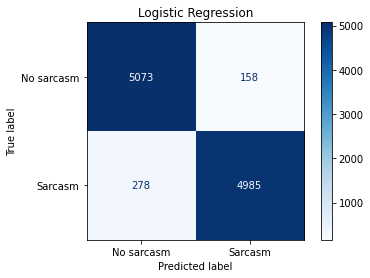

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test_full,
        y_test,
        display_labels=['No sarcasm', 'Sarcasm'],
        cmap=plt.cm.Blues )
disp.ax_.set_title("Logistic Regression")
plt.show()

### Naive Bayes

In [ ]:
hyperparams_nb = {
        'alpha': np.logspace(-9,-9, num=100)
}


In [ ]:
clf_nb =RandomizedSearchCV(MultinomialNB(), hyperparams_nb, verbose=1,cv=pds,
                           scoring='f1', n_jobs=-1, n_iter=100 ) 

In [ ]:
clf_nb.fit(vstack([X_train_full, X_valid_full]), y_train.append(y_valid))

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=MultinomialNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09...
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09])},
                   scoring='f1', verbose=1)

In [ ]:
preds = clf_nb.predict(X_test_full)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5186
           1       0.88      0.88      0.88      5308

    accuracy                           0.88     10494
   macro avg       0.88      0.88      0.88     10494
weighted avg       0.88      0.88      0.88     10494



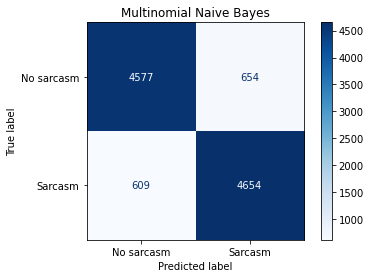

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf_nb,
        X_test_full,
        y_test,
        display_labels=['No sarcasm', 'Sarcasm'],
        cmap=plt.cm.Blues )
disp.ax_.set_title("Multinomial Naive Bayes")
plt.show()

### Suport Vector Machine (SVM)

In [ ]:
hyperparams_SVM =   {
    'C': np.logspace(-5, 5, 10), 
    'gamma': np.logspace(-5, 5, 10),
    'kernel': ['rbf', 'linear']} 

In [ ]:
clf_svm =RandomizedSearchCV(SVC(), hyperparams_SVM, verbose=1,cv=pds,
                           scoring='f1', n_jobs=-1, n_iter=10 ) 

In [ ]:
clf_svm.fit(vstack([X_train_full, X_valid_full]), y_train.append(y_valid))

Fitting 1 folds for each of 10 candidates, totalling 10 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                        'gamma': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                        'kernel': ['rbf', 'linear']},
                   scoring='f1', verbose=1)

In [ ]:
preds = clf_svm.predict(X_test_full)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5256
           1       0.96      0.96      0.96      5238

    accuracy                           0.96     10494
   macro avg       0.96      0.96      0.96     10494
weighted avg       0.96      0.96      0.96     10494



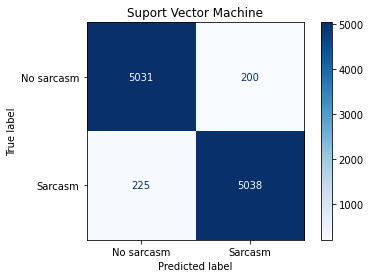

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf_svm,
        X_test_full,
        y_test,
        display_labels=['No sarcasm', 'Sarcasm'],
        cmap=plt.cm.Blues )
disp.ax_.set_title("Suport Vector Machine")
plt.show()

In [ ]:
clf_svm.get_params()

{'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_iter': 10,
 'n_jobs': -1,
 'param_distributions': {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
         2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
         7.74263683e+03, 1.00000000e+05]),
  'gamma': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
         2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
         7.74263683e+03, 1.000000